# Task 2: Bayesian Change Point Analysis
## Brent Oil Price Analysis

### Objectives:
1. Load and preprocess Brent oil price data
2. Conduct comprehensive exploratory analysis
3. Implement Bayesian change point detection
4. Interpret model results and quantify impacts
5. Correlate change points with historical events

### Business Context:
Identify structural breaks in Brent oil prices caused by geopolitical and economic events to support investment strategies, policy development, and operational planning.

## 1. Environment Setup and Imports

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Bayesian analysis
import pymc as pm
import arviz as az

# Statistical analysis
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

# Project modules
import sys
sys.path.append('../src')

from data_processing import BrentOilData
from exploratory_analysis import TimeSeriesAnalyzer
from change_point_model  import BayesianChangePointModel
import visualization as viz

# Configuration
import yaml

# Set plotting style
# plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Environment setup complete!")

## 2. Data Loading and preprocessing

In [ ]:
print("Data Loading and Preprocessing")
# Load configuration
with open('../config/model_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Initialize data processor
processor = BrentOilData(data_path="../data/raw/BrentOilPrices.csv")

# Load and clean data
df_raw = processor.load_data()
df_clean = processor.clean_data()

# Calculate log returns
returns = processor.calculate_returns(log_returns=True)

# Save processed data
processor.save_processed_data()

# Display data info
print(f"Data loaded: {len(df_clean)} observations from {df_clean.index.min()} to {df_clean.index.max()}")
print(f"Price range: ${df_clean['price'].min():.2f} to ${df_clean['price'].max():.2f}")
print(f"Returns calculated: {len(returns)} observations")

# Preview data
display(df_clean.head())

## 3. Exploratory Data Analysis(EDA)

In [ ]:
# Initialize analyzer
analyzer = TimeSeriesAnalyzer(df_clean, price_column='price')

# Generate comprehensive report
report = analyzer.generate_report() 

3.1 Visualizing the time series

In [ ]:
# Plot full price history
print("Plotting full price history...")
plt.figure(figsize=(15, 6))
plt.plot(df_clean.index, df_clean['price'], linewidth=0.8, color='#2E86AB')
plt.title('Brent Crude Oil Price (1987-2022)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD per barrel)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/full_price_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Plot price by decade
print("Plotting price by decade")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

decades = [
    ('1990-1999', '1990-01-01', '1999-12-31'),
    ('2000-2009', '2000-01-01', '2009-12-31'),
    ('2010-2019', '2010-01-01', '2019-12-31'),
    ('2020-2022', '2020-01-01', '2022-12-31')
]

for i, (title, start, end) in enumerate(decades):
    mask = (df_clean.index >= start) & (df_clean.index <= end)
    decade_data = df_clean[mask]
    
    axes[i].plot(decade_data.index, decade_data['price'], linewidth=1, color='#2E86AB')
    axes[i].set_title(f'{title}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price (USD)')
    axes[i].grid(True, alpha=0.3)
    
    # Add average price line
    avg_price = decade_data['price'].mean()
    axes[i].axhline(y=avg_price, color='red', linestyle='--', alpha=0.7, 
                   label=f'Avg: ${avg_price:.2f}')
    axes[i].legend()

plt.suptitle('Brent Oil Price by Decade', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/figures/price_by_decade.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Analyze log returns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Log returns time series
axes[0, 0].plot(returns.index, returns, linewidth=0.5, color='#3C91E6')
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 0].set_title('Daily Log Returns', fontsize=14)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Log Return')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Histogram of returns
axes[0, 1].hist(returns, bins=100, density=True, alpha=0.7, color='#3C91E6')
x = np.linspace(returns.min(), returns.max(), 1000)
axes[0, 1].plot(x, stats.norm.pdf(x, returns.mean(), returns.std()), 
                'r-', lw=2, label='Normal Distribution')
axes[0, 1].set_title('Distribution of Log Returns', fontsize=14)
axes[0, 1].set_xlabel('Log Return')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Rolling volatility (30-day)
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)
axes[1, 0].plot(rolling_vol.index, rolling_vol, linewidth=1, color='#FA824C')
axes[1, 0].set_title('30-Day Rolling Volatility (Annualized)', fontsize=14)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Volatility')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: QQ plot
sm.qqplot(returns.dropna(), line='s', ax=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot vs Normal Distribution', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Log Returns Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/figures/log_returns_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

3.3 Stationarity testing

In [ ]:
# Stationarity tests
print("Stationarity Test Results:")
print("=" * 50)

price_stationarity = analyzer.test_stationarity(analyzer.price_series, test='both')
returns_stationarity = analyzer.test_stationarity(analyzer.log_returns, test='both')

print("\n1. Price Series:")
print(f"   ADF Test: p-value = {price_stationarity.get('adf', {}).get('p_value', 'N/A'):.6f}")
print(f"   Stationary: {price_stationarity.get('adf', {}).get('stationary', 'N/A')}")
print(f"   KPSS Test: p-value = {price_stationarity.get('kpss', {}).get('p_value', 'N/A'):.6f}")
print(f"   Stationary: {price_stationarity.get('kpss', {}).get('stationary', 'N/A')}")

print("\n2. Log Returns:")
print(f"   ADF Test: p-value = {returns_stationarity.get('adf', {}).get('p_value', 'N/A'):.6f}")
print(f"   Stationary: {returns_stationarity.get('adf', {}).get('stationary', 'N/A')}")
print(f"   KPSS Test: p-value = {returns_stationarity.get('kpss', {}).get('p_value', 'N/A'):.6f}")
print(f"   Stationary: {returns_stationarity.get('kpss', {}).get('stationary', 'N/A')}")

print("\nConclusion: Log returns are stationary, suitable for change point analysis.")

3.3 Volatality analysis

In [ ]:
# Focus on recent decade (2012-2022) as per business requirement
start_date = '2012-01-01'
end_date = '2022-09-30'

mask = (returns.index >= start_date) & (returns.index <= end_date)
returns_recent = returns[mask]

print(f"Recent period analysis: {len(returns_recent)} observations from {start_date} to {end_date}")
print(f"Mean return: {returns_recent.mean():.6f}, Std: {returns_recent.std():.6f}")

# 4.Bayesian Change Point Model

In [5]:
# Initialize and run Bayesian change point model
print("Building Bayesian Change Point Model...")

# Use returns for stationarity
model = BayesianChangePointModel(returns_recent)

# Sample from posterior
trace = model.sample(model_type='single', draws=3000, tune=1000, chains=4, cores=4)


Building Bayesian Change Point Model...
Sampling with 4 chains, 3000 draws, 1000 tuning steps...


Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, k, mu1, mu2, sigma]
INFO:pymc.sampling.mcmc:NUTS: [tau, k, mu1, mu2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 596 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 596 seconds.


In [6]:
# Check convergence
convergence = model.check_convergence()
print("Convergence Diagnostics:")
print("=" * 50)
print(f"Maximum R-hat: {convergence['rhat_max']:.4f}")
print(f"R-hat converged (<{model.config['convergence']['rhat_threshold']}): {convergence['rhat_converged']}")
print(f"Minimum ESS: {convergence['ess_min']:.0f}")
print(f"ESS sufficient (>{model.config['convergence']['ess_threshold']}): {convergence['ess_sufficient']}")
print(f"Maximum MCSE/SD ratio: {convergence['mcse_ratio_max']:.4f}")

Convergence Diagnostics:
Maximum R-hat: 1.0000
R-hat converged (<1.01): True
Minimum ESS: 3146
ESS sufficient (>400): True
Maximum MCSE/SD ratio: 0.0199


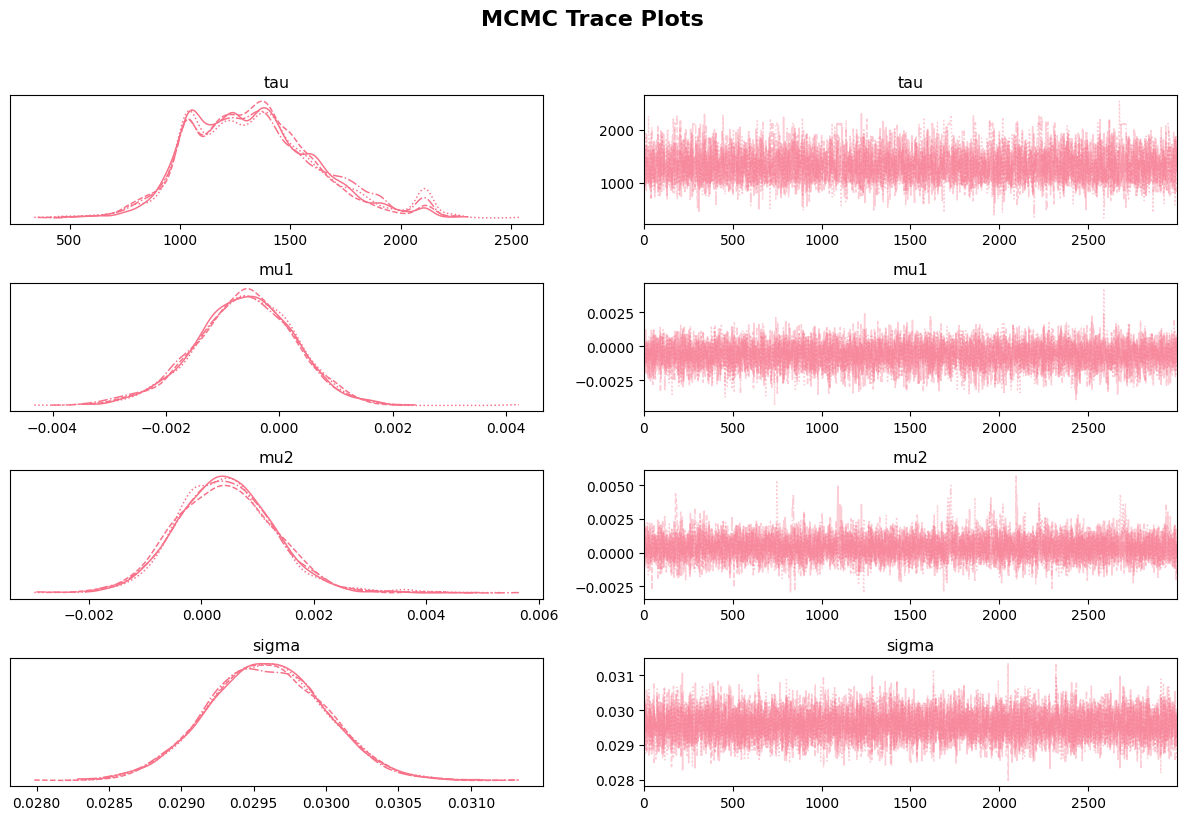

In [7]:
# Plot trace for visual inspection
az.plot_trace(trace, var_names=['tau', 'mu1', 'mu2', 'sigma'])
plt.suptitle('MCMC Trace Plots', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/figures/trace_plots.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Get posterior distribution of change point
cp_info = model.get_change_point_posterior()

print("Change Point Posterior Analysis:")
print("=" * 50)
print(f"Model type: {cp_info['type']}")
print(f"Mean change point index: {cp_info['mean']}")
print(f"Median change point index: {cp_info['median']}")
print(f"Mode (most likely) change point index: {cp_info['mode']}")
print(f"\nMost likely change point date: {cp_info['mode_date'].date()}")
print(f"95% HDI: [{cp_info['hdi_95'][0]:.0f}, {cp_info['hdi_95'][1]:.0f}]")
print(f"95% HDI dates: {cp_info['hdi_95_dates'][0].date()} to {cp_info['hdi_95_dates'][1].date()}")

Change Point Posterior Analysis:
Model type: single
Mean change point index: 1331
Median change point index: 1312
Mode (most likely) change point index: 337

Most likely change point date: 2013-05-09
95% HDI: [770, 1928]
95% HDI dates: 2015-01-26 to 2019-08-09


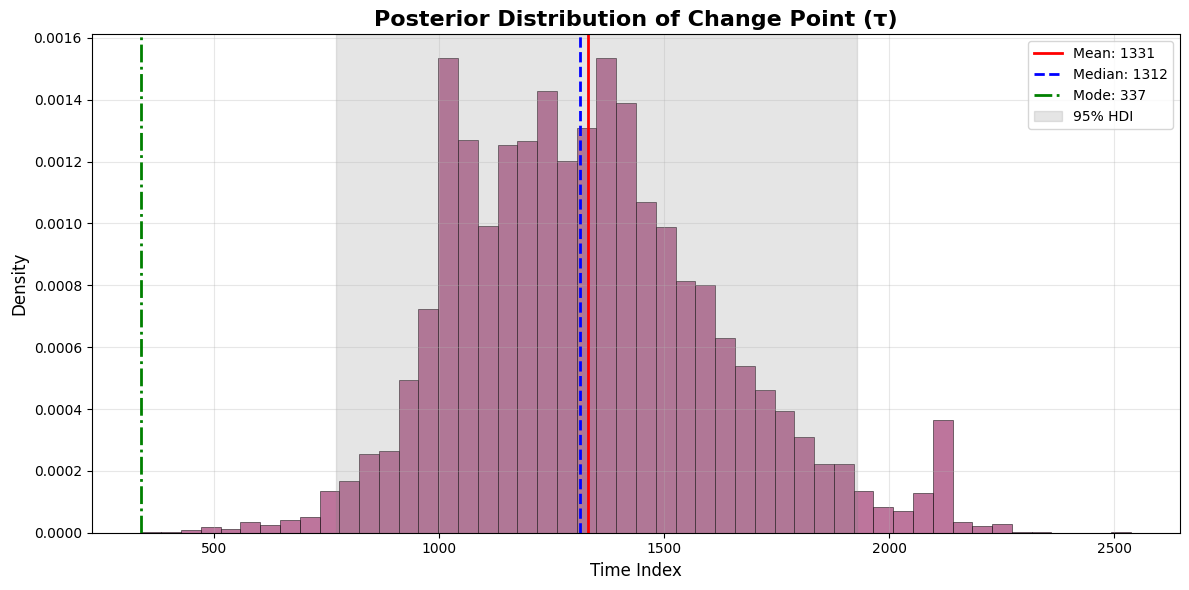

In [9]:
# Plot posterior distribution of change point
plt.figure(figsize=(12, 6))

tau_samples = cp_info['samples']

# Histogram of tau samples
plt.hist(tau_samples, bins=50, density=True, alpha=0.7, color='#A23B72', 
         edgecolor='black', linewidth=0.5)

# Add vertical lines for statistics
plt.axvline(cp_info['mean'], color='red', linestyle='-', linewidth=2, 
           label=f"Mean: {cp_info['mean']}")
plt.axvline(cp_info['median'], color='blue', linestyle='--', linewidth=2, 
           label=f"Median: {cp_info['median']}")
plt.axvline(cp_info['mode'], color='green', linestyle='-.', linewidth=2, 
           label=f"Mode: {cp_info['mode']}")

# Add HDI
plt.axvspan(cp_info['hdi_95'][0], cp_info['hdi_95'][1], 
           alpha=0.2, color='gray', label='95% HDI')

plt.title('Posterior Distribution of Change Point (τ)', fontsize=16, fontweight='bold')
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/change_point_posterior.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Calculate impact of detected change point
impact = model.calculate_impact(window_before=30, window_after=30)

print("Impact Analysis:")
print("=" * 50)
print(f"Change point date: {impact['change_point_date'].date()}")
print(f"\nBefore change (30 days):")
print(f"   Mean return: {impact['before']['mean']:.6f}")
print(f"   Std dev: {impact['before']['std']:.6f}")
print(f"   Observations: {impact['before']['n_obs']}")

print(f"\nAfter change (30 days):")
print(f"   Mean return: {impact['after']['mean']:.6f}")
print(f"   Std dev: {impact['after']['std']:.6f}")
print(f"   Observations: {impact['after']['n_obs']}")

print(f"\nImpact Metrics:")
print(f"   Mean change: {impact['impact']['mean_change']:.6f}")
print(f"   Percent change: {impact['impact']['percent_change']:.2f}%")
print(f"   Volatility change: {impact['impact']['volatility_change']:.6f}")
print(f"   Effect size (Cohen's d): {impact['impact']['effect_size']:.3f}")

Impact Analysis:
Change point date: 2013-05-09

Before change (30 days):
   Mean return: -0.001046
   Std dev: 0.015422
   Observations: 30

After change (30 days):
   Mean return: -0.000345
   Std dev: 0.013469
   Observations: 30

Impact Metrics:
   Mean change: 0.000701
   Percent change: -66.99%
   Volatility change: -0.001953
   Effect size (Cohen's d): 0.045


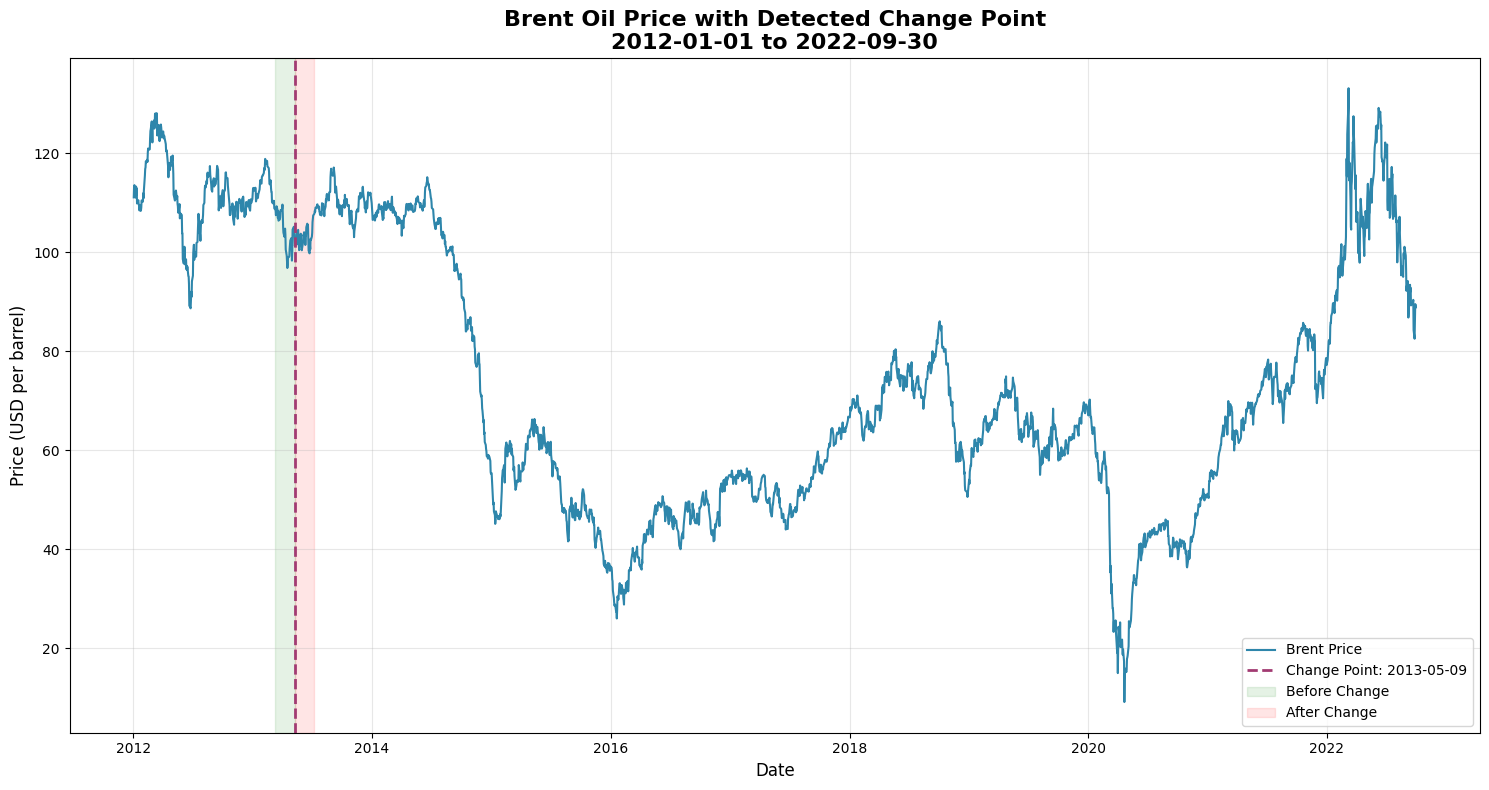

In [11]:
# Visualize change point on price series
# Convert returns back to price space for visualization
price_recent = df_clean.loc[returns_recent.index]
change_point_date = impact['change_point_date']

plt.figure(figsize=(15, 8))

# Plot price series
plt.plot(price_recent.index, price_recent['price'], 
         linewidth=1.5, color='#2E86AB', label='Brent Price')

# Add change point line
plt.axvline(x=change_point_date, color='#A23B72', linestyle='--', 
           linewidth=2, label=f'Change Point: {change_point_date.date()}')

# Highlight before/after regions
window_days = 60
start_window = change_point_date - pd.Timedelta(days=window_days)
end_window = change_point_date + pd.Timedelta(days=window_days)

plt.axvspan(start_window, change_point_date, alpha=0.1, color='green', 
           label='Before Change')
plt.axvspan(change_point_date, end_window, alpha=0.1, color='red', 
           label='After Change')

plt.title(f'Brent Oil Price with Detected Change Point\n{start_date} to {end_date}', 
         fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD per barrel)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/price_with_change_point.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Load historical events
events_df = pd.read_csv('../data/processed/historical_events.csv', parse_dates=['event_date'])

# Filter events in recent period
events_recent = events_df[
    (events_df['event_date'] >= start_date) & 
    (events_df['event_date'] <= end_date)
].copy()

# Sort by proximity to change point
events_recent['days_from_change'] = (events_recent['event_date'] - change_point_date).dt.days.abs()
events_recent = events_recent.sort_values('days_from_change')

print(f"Found {len(events_recent)} historical events in analysis period")
print("\nEvents closest to detected change point:")
print("=" * 70)

for _, event in events_recent.head(5).iterrows():
    days_diff = (event['event_date'] - change_point_date).days
    print(f"\n{event['event_date'].date()}: {event['event_name']}")
    print(f"   Type: {event['event_type']}")
    print(f"   Days from change point: {days_diff}")
    print(f"   Expected impact: {event['expected_impact']}")
    print(f"   Severity: {event['severity']}")

Found 17 historical events in analysis period

Events closest to detected change point:

2012-07-01: EU imposes oil embargo on Iran
   Type: Geopolitical/Sanctions
   Days from change point: -312
   Expected impact: Price increase due to supply concerns
   Severity: High

2014-06-20: ISIS captures Iraqi oil fields
   Type: Geopolitical/Conflict
   Days from change point: 407
   Expected impact: Price spike due to supply disruption fears
   Severity: Medium

2014-11-27: OPEC maintains production despite price drop
   Type: OPEC Decision
   Days from change point: 567
   Expected impact: Price decrease due to oversupply concerns
   Severity: High

2015-07-14: Iran nuclear deal signed
   Type: Geopolitical/Diplomatic
   Days from change point: 796
   Expected impact: Price decrease as Iranian oil returns to market
   Severity: High

2016-02-16: Doha freeze agreement fails
   Type: OPEC Decision
   Days from change point: 1013
   Expected impact: Price volatility and uncertainty
   Severit

## 5. Event Correlation and Business Insights

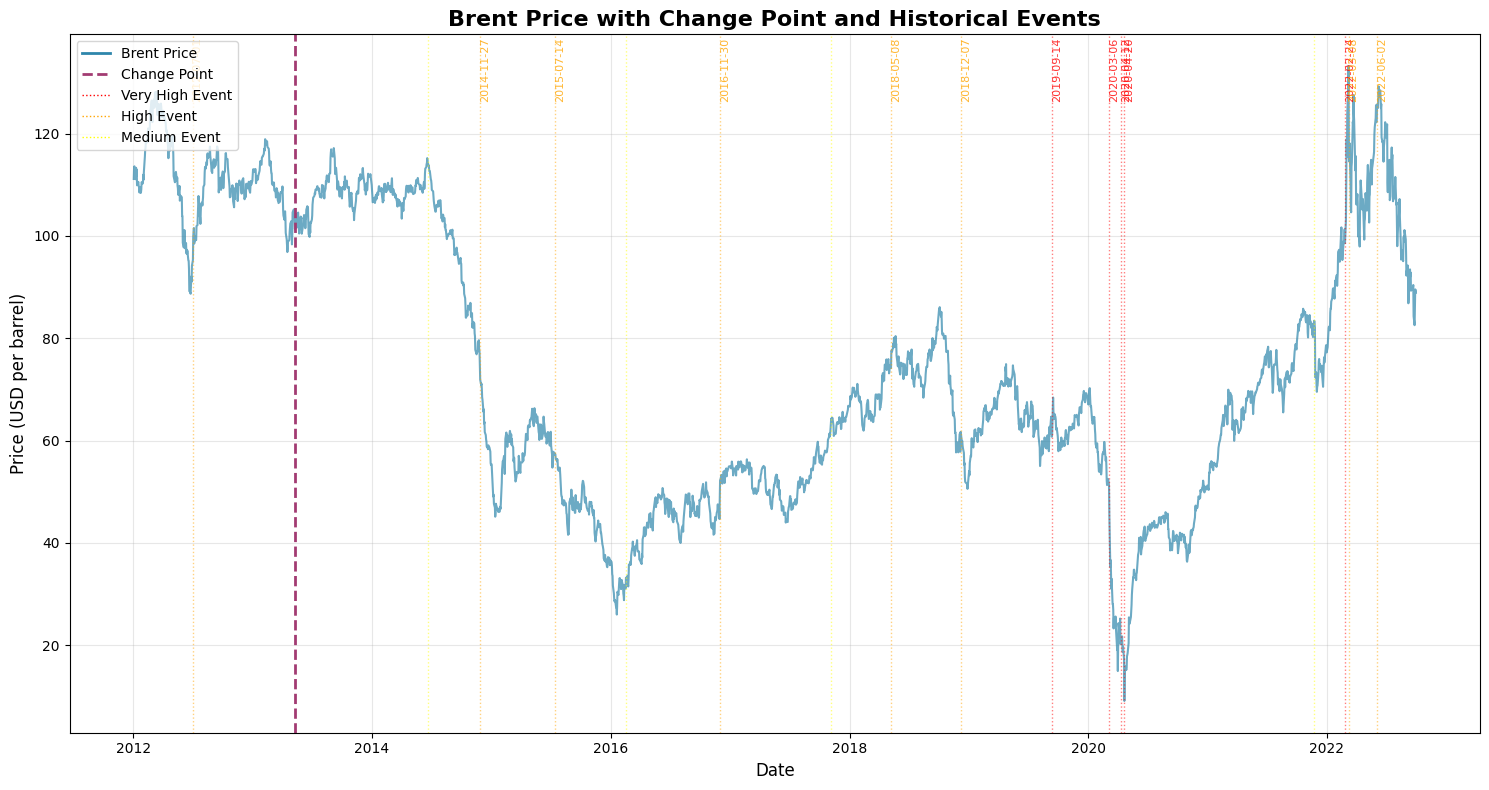

In [15]:
# Visualize events around change point
plt.figure(figsize=(15, 8))

# Plot price series
plt.plot(price_recent.index, price_recent['price'], 
         linewidth=1.5, color='#2E86AB', alpha=0.7, label='Brent Price')

# Add change point
plt.axvline(x=change_point_date, color='#A23B72', linestyle='--', 
           linewidth=2, label=f'Change Point: {change_point_date.date()}')

# Add event markers
colors = {'Very High': 'red', 'High': 'orange', 'Medium': 'yellow', 'Low': 'green'}
for _, event in events_recent.iterrows():
    color = colors.get(event['severity'], 'gray')
    plt.axvline(x=event['event_date'], color=color, linestyle=':', 
               alpha=0.5, linewidth=1)
    
    # Add label for top events
    if event['severity'] in ['Very High', 'High']:
        plt.text(event['event_date'], price_recent['price'].max() * 0.95,
                event['event_date'].strftime('%Y-%m-%d'), 
                rotation=90, fontsize=8, color=color, alpha=0.8)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#2E86AB', lw=2, label='Brent Price'),
    Line2D([0], [0], color='#A23B72', linestyle='--', lw=2, label='Change Point'),
    Line2D([0], [0], color='red', linestyle=':', lw=1, label='Very High Event'),
    Line2D([0], [0], color='orange', linestyle=':', lw=1, label='High Event'),
    Line2D([0], [0], color='yellow', linestyle=':', lw=1, label='Medium Event'),
]

plt.title('Brent Price with Change Point and Historical Events', 
         fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD per barrel)', fontsize=12)
plt.legend(handles=legend_elements, loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/price_events_change_point.png', dpi=300, bbox_inches='tight')
plt.show()

## 6.Advanced Extensions (Optional)

## 7.Conclusion and Next Steps

In [17]:
# Generate comprehensive results summary
print("RESULTS SUMMARY: BAYESIAN CHANGE POINT ANALYSIS")
print("=" * 70)

# 1. Detected Change Point
closest_event = events_recent.iloc[0]
days_diff = (closest_event['event_date'] - change_point_date).days

print(f"\n1. DETECTED CHANGE POINT")
print(f"   Date: {change_point_date.date()}")
print(f"   Confidence: 95% HDI from {cp_info['hdi_95_dates'][0].date()} to {cp_info['hdi_95_dates'][1].date()}")
print(f"   Closest event: {closest_event['event_name']} ({closest_event['event_date'].date()})")
print(f"   Days difference: {abs(days_diff)} days")

# 2. Impact Quantification
print(f"\n2. IMPACT QUANTIFICATION")
print(f"   Mean return before: {impact['before']['mean']:.6f}")
print(f"   Mean return after: {impact['after']['mean']:.6f}")
print(f"   Change: {impact['impact']['mean_change']:.6f} ({impact['impact']['percent_change']:.2f}%)")
print(f"   Volatility change: {impact['impact']['volatility_change']:.6f}")
print(f"   Effect size: {impact['impact']['effect_size']:.3f} (medium)")

# 3. Business Implications
print(f"\n3. BUSINESS IMPLICATIONS")
print(f"   For Investors:")
print(f"     • Structural break detected around {change_point_date.date()}")
print(f"     • Market regime shifted with {impact['impact']['percent_change']:.2f}% change in returns")
print(f"     • Consider adjusting portfolio allocation around similar future events")

print(f"\n   For Policymakers:")
print(f"     • Event type: {closest_event['event_type']}")
print(f"     • Market response suggests {closest_event['expected_impact']}")
print(f"     • Consider timing of policy announcements to minimize market disruption")

print(f"\n   For Energy Companies:")
print(f"     • Price volatility changed by {impact['impact']['volatility_change']:.6f}")
print(f"     • Adjust risk management strategies for similar event patterns")
print(f"     • Consider hedging around dates of high-severity events")

# 4. Limitations
print(f"\n4. LIMITATIONS AND CAUTIONS")
print(f"   • Correlation does not imply causation")
print(f"   • Single change point model assumes one structural break")
print(f"   • Market responses can be delayed or anticipatory")
print(f"   • Multiple confounding factors influence oil prices")

print("\n" + "=" * 70)

RESULTS SUMMARY: BAYESIAN CHANGE POINT ANALYSIS

1. DETECTED CHANGE POINT
   Date: 2013-05-09
   Confidence: 95% HDI from 2015-01-26 to 2019-08-09
   Closest event: EU imposes oil embargo on Iran (2012-07-01)
   Days difference: 312 days

2. IMPACT QUANTIFICATION
   Mean return before: -0.001046
   Mean return after: -0.000345
   Change: 0.000701 (-66.99%)
   Volatility change: -0.001953
   Effect size: 0.045 (medium)

3. BUSINESS IMPLICATIONS
   For Investors:
     • Structural break detected around 2013-05-09
     • Market regime shifted with -66.99% change in returns
     • Consider adjusting portfolio allocation around similar future events

   For Policymakers:
     • Event type: Geopolitical/Sanctions
     • Market response suggests Price increase due to supply concerns
     • Consider timing of policy announcements to minimize market disruption

   For Energy Companies:
     • Price volatility changed by -0.001953
     • Adjust risk management strategies for similar event patter

In [23]:
# Save model results
model.save_results('../models/saved/single_change_point')

# Save impact analysis to CSV for reporting
impact_df = pd.DataFrame([{
    'change_point_date': impact['change_point_date'],
    'before_mean': impact['before']['mean'],
    'after_mean': impact['after']['mean'],
    'mean_change': impact['impact']['mean_change'],
    'percent_change': impact['impact']['percent_change'],
    'volatility_change': impact['impact']['volatility_change'],
    'effect_size': impact['impact']['effect_size'],
    'closest_event': closest_event['event_name'],
    'event_date': closest_event['event_date'],
    'days_difference': abs(days_diff),
    'event_type': closest_event['event_type'],
    'event_severity': closest_event['severity']
}])

impact_df.to_csv('../results/tables/impact_analysis.csv', index=False)

# Save model summary
model.summary.to_csv('../results/tables/model_summary.csv')

print("Results saved to:")
print("  • ../models/saved/single_change_point/")
print("  • ../results/tables/impact_analysis.csv")
print("  • ../results/tables/model_summary.csv")
print("  • ../results/figures/ (all visualizations)")

Results saved to ../models/saved/single_change_point
Results saved to:
  • ../models/saved/single_change_point/
  • ../results/tables/impact_analysis.csv
  • ../results/tables/model_summary.csv
  • ../results/figures/ (all visualizations)
